In [1]:
import numpy as np
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# lorenzp/adversialml/src/pytorch-CelebAHQ/data/

# lorenzp/adversialml/src/pytorch-CelebAHQ/data/32x32_resnet50_adversarial_images/resnet50_images_smiling_fgsm
# /home/lorenzp/adversialml/src/pytorch-CelebAHQ/data/32x32_resnet50_adversarial_images/resnet50_images_adv_fgsm

# my_path = '/home/lorenzp/adversialml/src/pytorch-CelebAHQ'
# advs = torch.load(my_path + '/data/32x32_resnet50_adversarial_images/resnet50_images_adv_smiling_fgsm')
# images = torch.load(my_path + '/data/32x32_resnet50_adversarial_images/resnet50_images_smiling_fgsm')


my_path = '/home/lorenzp/adversialml/src/data/attacks/run_1/cif10/wrn_28_10_10'

In [3]:
originals = torch.load(my_path + os.sep + 'bim'  + os.sep + 'images')
fgsms     = torch.load(my_path + os.sep + 'fgsm' + os.sep + 'images_adv')
bims      = torch.load(my_path + os.sep + 'bim'  + os.sep + 'images_adv')
deepfools = torch.load(my_path + os.sep + 'df'   + os.sep + 'images_adv')
pgds      = torch.load(my_path + os.sep + 'pgd'  + os.sep + 'images_adv')
cws       = torch.load(my_path + os.sep + 'cw'   + os.sep + 'images_adv')


attacks = [originals, fgsms, pgds, bims, deepfools, cws]
attack_name = ['normal','FGSM', ' PGD', 'BIM', 'Deepfool', 'C&W']

In [4]:
def plot_spectrum( fft_im, vmin, scale_factor):
    fshift0 = np.fft.fftshift(fft_im) #shifts the zero-frequency component to the center of the spectrum
    magnitude_spectrum = (np.log10(np.abs(fshift0*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)), vmin=vmin)
    
    print("magnitude_spectrum", magnitude_spectrum.min(),magnitude_spectrum.max(), )
    return plt.imshow(np.abs(magnitude_spectrum),  vmin=vmin)
    
def plot_spectrum_diff(fft1, fft2, scale_factor):
    norm = fft1-fft2
    diff = np.abs(norm)
    
    magnitude_spectrum = (np.log10(np.abs(diff*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)))
    
    return plt.imshow(np.abs(magnitude_spectrum), cmap='Blues')
                          
def plot_im(im):
    return plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
                          
def plot_diff(im1, im2, scale_factor=0):
    im1 = im1.numpy()
    im2 = im2.numpy()
    diff = np.abs(im1-im2)
    #print(np.linalg.norm(diff))
    magnitude_spectrum = (np.log10(np.abs(diff*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    
    return plt.imshow(np.transpose(magnitude_spectrum, (1, 2, 0)))  

def max_projection_fft(x):
   
    x_image = np.fft.fft2(x)
    #calculate the max for each pixel over the channels
    max_image = x_image[0,:,:].copy()
    #x_image = np.abs(x_image) #only look at the magnitude
    n = len(max_image)
    for i in range(n):
        for j in range(n):
            max_image[i,j] = max(np.abs(x_image[:,i,j]))
    return max_image

def max_proj(image):
    (_,n,m) = np.shape(image)
    new_image = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            new_image[i,j] = np.max(image[:,i,j])
    return new_image

def average_spectrum(images):
    im_sum = images[0]
    for i in range(1,999):
        img = images[i]
        img = np.abs(np.fft.fft2(img))
        #img = max_proj(img)
        if np.max(img)>0:
            img *= 1/np.max(img)
            im_sum += img
    return im_sum/1000

#PMI

def calc_MI(x, y):
    c_xy = np.histogram2d(x, y)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def patch(image, start_x, start_y, size):
    patch_im = image[:,start_x:start_x+size,start_y:start_y+size].numpy()
    return patch_im

def calculate_pmi_image(image, noise, patch_size):
    pmi_image = np.zeros((24,24))
    for i in range(24):
        for j in range(24):
            pmi_image[i,j] = calc_MI(patch(image, i,j,patch_size).flatten(), patch(noise, i,j,patch_size).flatten())
    return pmi_imag

im.min() tensor(0.0510)
im.max() tensor(0.7882)
magnitude_spectrum 0.361779975799976 1.0
AxesImage(473.236,852.692;304.364x287.788)
magnitude_spectrum 0.4620231596545594 1.0
norm:  AxesImage(108,162;304.364x287.788)


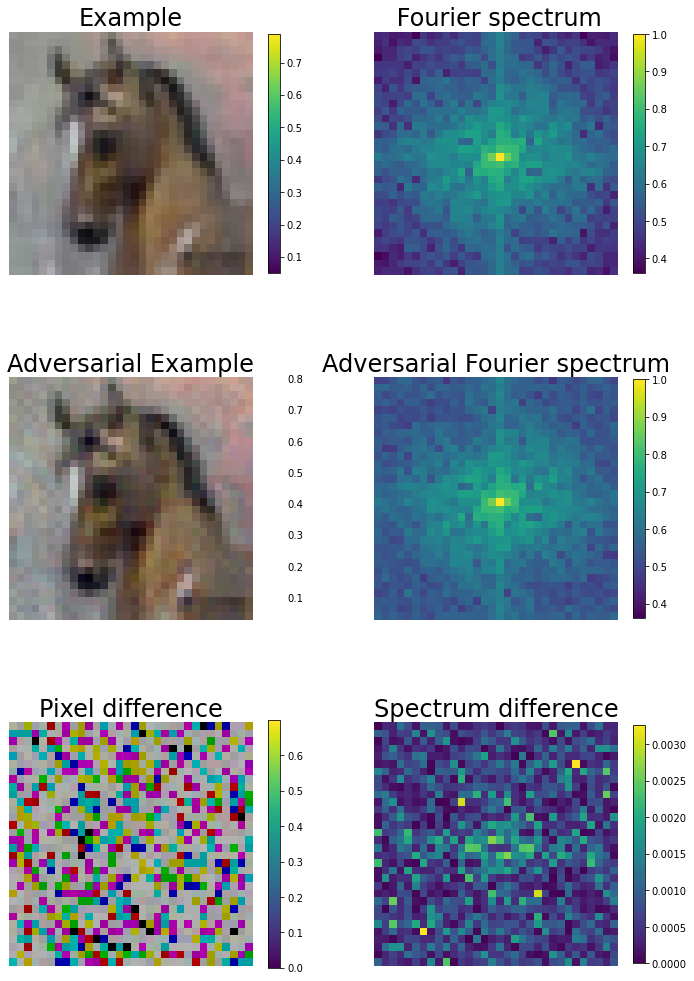

In [19]:
fig = plt.figure(figsize=(12,18))
im_num = 200
attack = attacks[3]
im = originals[im_num].cpu()
ad = attack[im_num].cpu()

print("im.min()", im.min())
print("im.max()", im.max())


#normal image
ax0 = plt.subplot(3,2,1)
plt.title('Example', fontsize=24)

im1 = plot_im(im)
plt.axis('off')
cb = plt.colorbar(im1, shrink=0.83, alpha=0, filled=True, drawedges=False)
# cb.outline.set_color('white')
# cb.ax.tick_params(color="white")
ax1 = plt.subplot(3,2,2)
plt.title(' Fourier spectrum', fontsize=24)
fft = max_projection_fft(im)
ad_fft = max_projection_fft(ad)
ad_fft *= 1/np.max(ad_fft)
fft *= 1/np.max(fft)
scale_factor=5
m_n = (np.log10(np.abs(np.fft.fftshift(np.abs(fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
vmin = min(np.min(m_n),np.min(m_a))

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

spec = plot_spectrum( fft, vmin=vmin, scale_factor=5)
print(spec)
plt.axis('off')

fig.colorbar(spec, shrink=0.83)

#adversarial image
ax2 = plt.subplot(3,2,3)
plt.title('Adversarial Example', fontsize=24)
plot_im(ad)
cb = plt.colorbar(shrink=0.86, alpha=0, filled=False, drawedges=False)
cb.outline.set_color('white')
cb.ax.tick_params(color="white")
plt.axis('off')
plt.subplot(3,2,4)
plt.title('Adversarial Fourier spectrum', fontsize=24)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

spec2 = plot_spectrum(ad_fft, vmin=vmin,scale_factor=5)
plt.axis('off')
# plt.colorbar(shrink=0.9)
fig.colorbar(spec2, shrink=0.83)

#differences
ax3 = plt.subplot(3,2,5)


plt.title('Pixel difference', fontsize=24)
norm = plot_diff(im, ad, scale_factor=4)
print("norm: ", norm)
cb = plt.colorbar(norm, shrink=0.86, alpha=0, filled=True, drawedges=False)

# cb.ax.tick_params(color="white")
# # cb.ax.tick_labels([])
# cb.outline.set_color('white')
plt.axis('off')
plt.subplot(3,2,6)
plt.title('Spectrum difference', fontsize=24)
#norm = plot_spectrum_diff(fft, ad_fft, scale_factor=5)
im_last = plt.imshow(np.abs(ad_fft-fft))
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

plt.colorbar(im_last, shrink=0.83)
plt.axis('off')
#plt.colorbar()
plt.savefig('one_image_analysis', bbox_inches='tight')

magnitude_spectrum 0.3903950031584211 1.0
magnitude_spectrum 0.47868012953690536 1.0


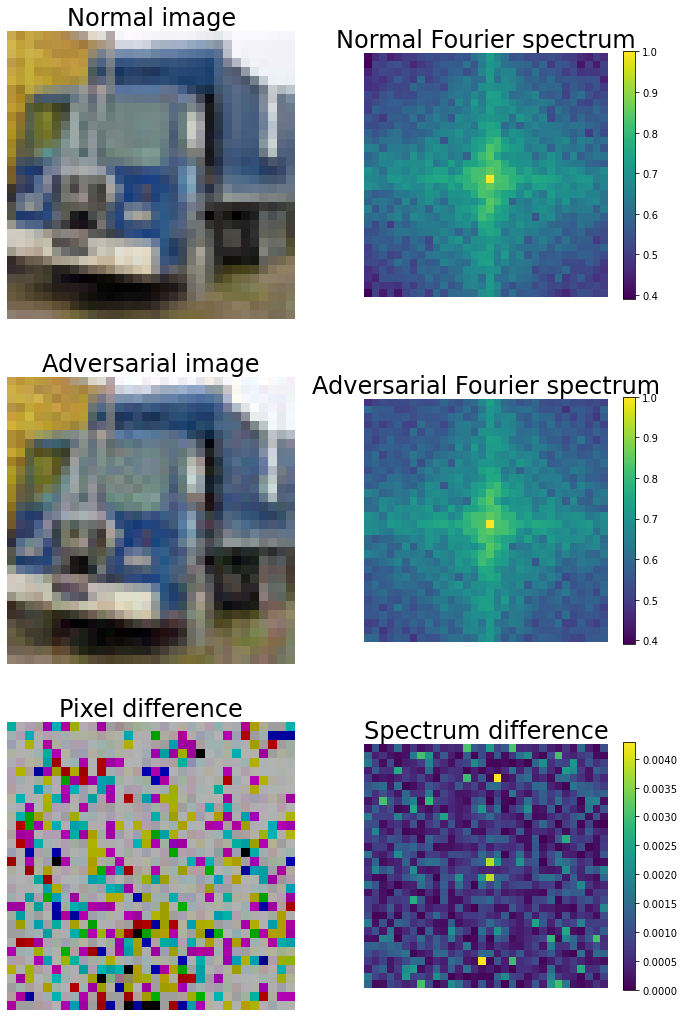

In [6]:
fig = plt.figure(figsize=(12,18))
im_num = 14
attack = attacks[3]
im = originals[im_num].cpu()
ad = attack[im_num].cpu()


#normal image
plt.subplot(3,2,1)
plt.title('Normal image', fontsize=24)
plot_im(im)
plt.axis('off')
ax1 = plt.subplot(3,2,2)
plt.title('Normal Fourier spectrum', fontsize=24)
fft = max_projection_fft(im)
ad_fft = max_projection_fft(ad)
ad_fft *= 1/np.max(ad_fft)
fft *= 1/np.max(fft)
scale_factor=5
m_n = (np.log10(np.abs(np.fft.fftshift(np.abs(fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
vmin = min(np.min(m_n),np.min(m_a))

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

spec = plot_spectrum( fft, vmin=vmin, scale_factor=5)
plt.axis('off')

fig.colorbar(spec, shrink=0.86)

#adversarial image
ax2 = plt.subplot(3,2,3)
plt.title('Adversarial image', fontsize=24)
plot_im(ad)
plt.axis('off')
plt.subplot(3,2,4)
plt.title('Adversarial Fourier spectrum', fontsize=24)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

spec2 = plot_spectrum(ad_fft, vmin=vmin,scale_factor=5)
plt.axis('off')
# plt.colorbar(shrink=0.9)
fig.colorbar(spec2, shrink=0.86)

#differences
ax3 = plt.subplot(3,2,5)


plt.title('Pixel difference', fontsize=24)
norm = plot_diff(im, ad, scale_factor=4)
plt.axis('off')
plt.subplot(3,2,6)
plt.title('Spectrum difference', fontsize=24)
#norm = plot_spectrum_diff(fft, ad_fft, scale_factor=5)
plt.imshow(np.abs(ad_fft-fft))
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

plt.colorbar(shrink=0.86)
plt.axis('off')
#plt.colorbar()
plt.savefig('one_image_analysis', bbox_inches='tight')
im_num+=1

In [6]:
im_num

2

In [7]:
plt.figure(figsize=(12,18))
im_num = 2
attack = attacks[3]
im = images[im_num].cpu()
ad = attack[im_num].cpu()

#normal image
plt.subplot(3,2,1)
plt.title('Normal image', fontsize=24)
plot_im(im)
plt.axis('off')
plt.subplot(3,2,2)
plt.title('Normal Fourier spectrum', fontsize=24)
fft = max_projection_fft(im)
ad_fft = max_projection_fft(ad)
ad_fft *= 1/np.max(ad_fft)
fft *= 1/np.max(fft)
scale_factor=5
m_n = (np.log10(np.abs(np.fft.fftshift(np.abs(fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
vmin = min(np.min(m_n),np.min(m_a))

plot_spectrum(fft, vmin=vmin, scale_factor=5)
plt.axis('off')
#plt.colorbar()
#adversarial image
plt.subplot(3,2,3)
plt.title('Adversarial image', fontsize=24)
plot_im(ad)
plt.axis('off')
plt.subplot(3,2,4)
plt.title('Adversarial Fourier spectrum', fontsize=24)


plot_spectrum(ad_fft, vmin=vmin,scale_factor=5)
plt.axis('off')
#plt.colorbar()
#differences
plt.subplot(3,2,5)
plt.title('Pixel difference', fontsize=24)
norm = plot_diff(im, ad, scale_factor=4)
plt.axis('off')
plt.subplot(3,2,6)
plt.title('Spectrum difference', fontsize=24)
#norm = plot_spectrum_diff(fft, ad_fft, scale_factor=5)
plt.imshow(np.abs(ad_fft-fft), cmap='Blues')
plt.axis('off')
#plt.colorbar()
plt.savefig('one_image_analysis')

NameError: name 'images' is not defined

<Figure size 864x1296 with 0 Axes>

In [8]:
my_path = '/home/harder/spectralrobustness/Paula'
originals = torch.load(my_path + '/adversarial_detection/data/clean_succes_10k')
deepfools = torch.load(my_path + '/adversarial_detection/data/foolbox/df')
bims      = torch.load(my_path + '/adversarial_detection/data/foolbox/bim')
cws       = torch.load(my_path + '/adversarial_detection/data/foolbox/cw')
pgds      = torch.load(my_path + '/adversarial_detection/data/foolbox/pgd')
fgsms      = torch.load(my_path + '/adversarial_detection/data/foolbox/fgsm')

attacks = [originals, fgsms, pgds, bims, deepfools, cws]
attack_name = ['normal','FGSM', ' PGD', 'BIM', 'Deepfool', 'C&W']

FileNotFoundError: [Errno 2] No such file or directory: '/home/harder/spectralrobustness/Paula/adversarial_detection/data/clean_succes_10k'

In [ ]:
images = []
spectra = []
diffs = []

for i in range(6):
    attack = attacks[i]
    im = attack[n].cpu()
    images[i] = im

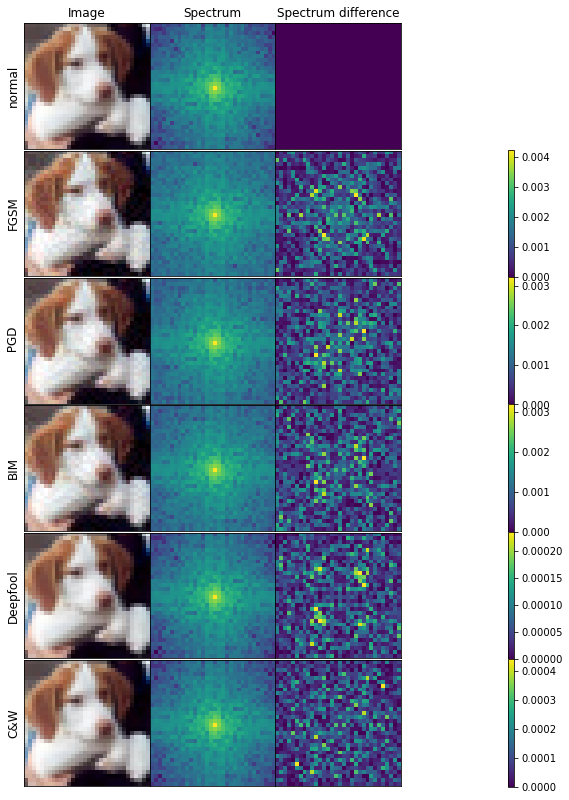

In [38]:
plt.figure(figsize=(9,18))
#fig.subplots_adjust(hspace=1, wspace=1)
n = 14
mins = []
dmins = []
dmaxs = []
for i in range(6):
    attack = attacks[i]
    im = attack[n].cpu()
    ad_fft = max_projection_fft(im)
    ad_fft *= 1/np.max(ad_fft)
    scale_factor=5
    m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    if i == 0:
        m_n = m_a
    
    mins.append(np.min(m_a))
    dmins.append(np.min(np.abs(m_a-m_n)))
    dmaxs.append(np.max(np.abs(m_a-m_n)))
dmax = max(dmaxs)
dmin = min(dmins)
for i in range(6):
    attack = attacks[i]
    im = attack[n].cpu()
    ad_fft = max_projection_fft(im)
    ad_fft *= 1/np.max(ad_fft)
    scale_factor=5
    m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    if i == 0:
        orig = im
        fft = ad_fft
        m_n = m_a
    vmin = min(mins)
    plt.subplot(6,4,4*i+1)
    plt.subplots_adjust(hspace=0, wspace=0, bottom=0.01)
    #plt.subplots_adjust( wspace=0,hspace=0,top=0.6)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    if i== 0:
        plt.title('Image')
    plt.ylabel(attack_name[i],Fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(6,4,4*i+2)
    plt.subplots_adjust( wspace=0,hspace=0,top=0.6, bottom=0.01)
    scale_factor=5
    fshift0 = np.fft.fftshift(ad_fft) #shifts the zero-frequency component to the center of the spectrum
    magnitude_spectrum = (np.log10(np.abs(fshift0*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)
    #plt.imshow(np.transpose(np.abs(magnitude_spectrum), (1, 2, 0)), vmin=vmin)
    plt.imshow(np.abs(magnitude_spectrum),  vmin=vmin)
    if i == 0:
        plt.title('Spectrum')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(6,4,4*i+3)
    #plt.subplots_adjust(hspace=0, wspace=0, bottom=0.01)
    plt.subplots_adjust( wspace=0,hspace=0,top=0.6, bottom=0.01)
    plt.imshow(np.abs(ad_fft-fft))
    plt.xticks([])
    plt.yticks([])
    if i== 0:
        plt.title('Spectrum difference')

        
    plt.subplot(6,4,4*i+4)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    if i > 0:
        plt.colorbar()
        
    #plt.subplots_adjust(hspace=0, wspace=0)
    plt.subplots_adjust( wspace=0,hspace=0,top=0.6, bottom=0.01)
plt.savefig('attack_compare')


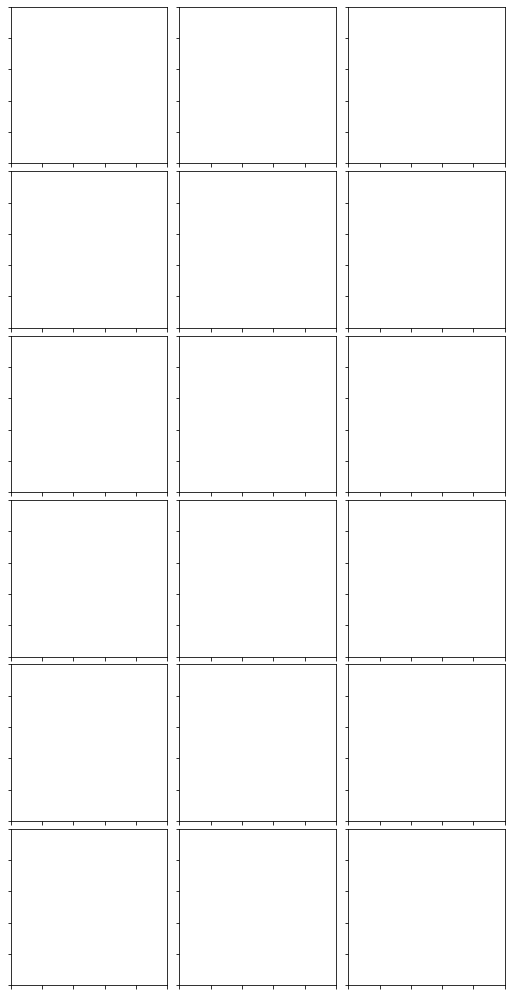

In [28]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (9,18))
gs1 = gridspec.GridSpec(6,3)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(18):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

plt.show()

In [10]:
np.median(fft)

(0.002148391267899258+0j)

In [40]:
np.abs(fft)

array([[1.        , 0.052806  , 0.03691645, ..., 0.01556137, 0.03691645,
        0.052806  ],
       [0.19286199, 0.03895488, 0.05262336, ..., 0.01521678, 0.02369497,
        0.01819532],
       [0.19586181, 0.04302481, 0.01104297, ..., 0.01047112, 0.01397877,
        0.03357813],
       ...,
       [0.08057187, 0.02192751, 0.01362665, ..., 0.00906991, 0.01411293,
        0.01827153],
       [0.19586181, 0.03357813, 0.01397877, ..., 0.01237072, 0.01104297,
        0.04302481],
       [0.19286199, 0.01819532, 0.02369497, ..., 0.02388716, 0.05262336,
        0.03895488]])

In [41]:
np.abs(ad_fft)

array([[1.        , 0.04905226, 0.03833799, ..., 0.02210336, 0.03833799,
        0.04905226],
       [0.19356462, 0.04160522, 0.05144498, ..., 0.01540317, 0.02714194,
        0.01612971],
       [0.19649992, 0.04386727, 0.01420106, ..., 0.01018889, 0.01556639,
        0.03231309],
       ...,
       [0.07847441, 0.01899474, 0.01179998, ..., 0.01105825, 0.01981458,
        0.01604073],
       [0.19649992, 0.03231309, 0.01556639, ..., 0.01437667, 0.01420106,
        0.04386727],
       [0.19356462, 0.01612971, 0.02714194, ..., 0.02473181, 0.05144498,
        0.04160522]])

In [12]:
diff = np.abs(fft)-np.abs(ad_fft)
scale_factor=5

In [13]:
m_n = (np.log10(np.abs(np.fft.fftshift(np.abs(fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)

In [14]:
m_a = (np.log10(np.abs(np.fft.fftshift(np.abs(ad_fft))*(np.power(10,scale_factor+1)-1)/np.power(10,scale_factor)+1/np.power(10,scale_factor)))+scale_factor)*1/(scale_factor+1)

In [16]:
np.mean(m_a)

0.6228171279630602

In [20]:
y_n = m_n.flatten()
y_a = m_a.flatten()
x = range(len(y_n))

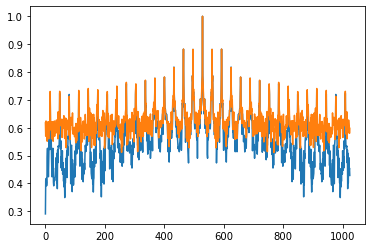

In [27]:
plt.plot(x,y_n,x,y_a)

In [31]:
vmin = min(np.min(m_n),np.min(m_a))

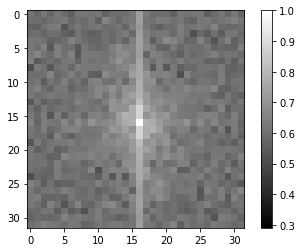

In [32]:
plt.imshow(m_a, cmap='gray', vmin=vmin)
plt.colorbar()

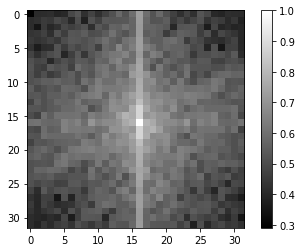

In [33]:
plt.imshow(m_n, cmap='gray',vmin=vmin)
plt.colorbar()

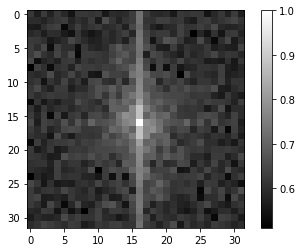

In [59]:
plt.imshow(m_a, cmap='gray')
plt.colorbar()

In [64]:
m_n[10:20,10:20] - m_a[10:20,10:20]

array([[-0.01212708, -0.00648406,  0.00225175, -0.01406354,  0.03993264,
        -0.00259658, -0.00145651, -0.01202561, -0.00777652,  0.02240717],
       [-0.01858338, -0.02952243, -0.06180981, -0.01467757, -0.04419504,
        -0.01115506, -0.00058671, -0.01557976, -0.01454578, -0.01803841],
       [-0.01464433, -0.0385916 , -0.01008445, -0.00052046, -0.00773591,
         0.00030309, -0.00054664,  0.00136359, -0.00298792,  0.00298987],
       [-0.00945526, -0.0343075 , -0.01578259, -0.01434578, -0.02455981,
         0.00942454,  0.0019092 ,  0.01039217,  0.01041712, -0.00228155],
       [-0.06649549,  0.03117649, -0.01136969, -0.01087636, -0.01820438,
        -0.00140358, -0.00023543,  0.00277958, -0.00778596,  0.00197747],
       [-0.03546298,  0.01119521, -0.00232331, -0.00251514,  0.00163923,
        -0.00476422, -0.00026322,  0.00872166, -0.00983041, -0.00088117],
       [-0.01172501,  0.00537891, -0.00541476, -0.02540037, -0.00273482,
         0.00533726,  0.        ,  0.00533726

In [65]:
x = m_n.flatten()
x_a = m_a.flatten()

In [ ]:
plt.plot

In [61]:
np.median(m_n)

0.5553858410150725

In [62]:
np.median(m_a)

0.6172509708279559

In [ ]:
## eps = [0.001, 0.01, 0.1, 1]
successes = [0.0025, 0.91, 1.0 , 1.0]
norm_rates = [0.6,0.807, 0.999, 1.0]
ad_rates = [0.4,0.825, 0.999, 1.0]

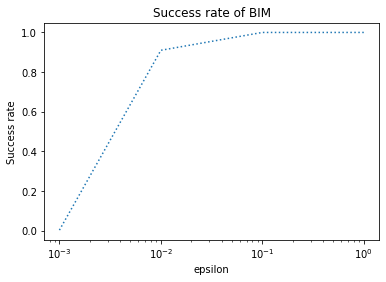

In [11]:
plt.semilogx(eps, successes, linestyle='dotted')
plt.title('Success rate of BIM')
plt.ylabel('Success rate')
plt.xlabel('epsilon')
plt.savefig('succes_bim')

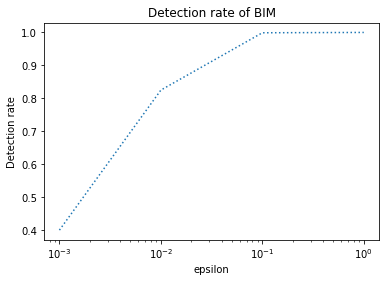

In [18]:
plt.semilogx(eps, ad_rates, linestyle='dotted')
plt.title('Detection rate of BIM')
plt.ylabel('Detection rate')
plt.xlabel('epsilon')
plt.savefig('detection_bim')